# Assignment 5 Q.1

## Importing libraries

In [1]:
# Import necessary libraries
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import requests
import matplotlib.pyplot as plt
import random
import zipfile
import os
import zipfile
import shutil
import random
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
# Create dataset directories
dataset_path = "/content/dataset"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")


In [3]:
for category in ["duck", "chicken"]:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)


## Helper function

In [4]:
def extract_images(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall("/tmp/temp_extract")  # Temporary path

    # Move image files to final destination (flattening)
    os.makedirs(extract_path, exist_ok=True)
    for root, _, files in os.walk("/tmp/temp_extract"):
        for file in files:
            if file.endswith(('.jpg', '.png', '.jpeg')):
                shutil.move(os.path.join(root, file), os.path.join(extract_path, file))

    shutil.rmtree("/tmp/temp_extract")  # Clean up
    print(f"Extracted and flattened images to {extract_path}")


In [5]:
def clean_hidden_files(root_dir):
    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.startswith("._"):
                os.remove(os.path.join(root, file))

In [6]:
def split_data(source_dir, train_dest, val_dest, test_dest, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    images = [img for img in os.listdir(source_dir) if img.endswith(('.jpg', '.png', '.jpeg'))]

    # Split into train, validation, and test
    train_files, test_files = train_test_split(images, test_size=(val_ratio + test_ratio), random_state=42)
    val_files, test_files = train_test_split(test_files, test_size=test_ratio/(val_ratio + test_ratio), random_state=42)

    # Move files to respective directories
    for file in train_files:
        shutil.move(os.path.join(source_dir, file), os.path.join(train_dest, file))
    for file in val_files:
        shutil.move(os.path.join(source_dir, file), os.path.join(val_dest, file))
    for file in test_files:
        shutil.move(os.path.join(source_dir, file), os.path.join(test_dest, file))

    print(f"Split data from {source_dir}: Train({len(train_files)}), Val({len(val_files)}), Test({len(test_files)})")


In [7]:
def plot_random_images(directory, title, num_images=5):
    categories = ["duck", "chicken"]
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    i = 0

    while i < num_images:
        category = random.choice(categories)
        img_folder = os.path.join(directory, category)
        img_file = random.choice(os.listdir(img_folder))

        # Skip system/hidden files
        if img_file.startswith("._") or not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        try:
            img_path = os.path.join(img_folder, img_file)
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(category.capitalize())
            axes[i].axis("off")
            i += 1
        except Exception as e:
            print(f"Skipping file {img_file}: {e}")
            continue

    plt.suptitle(title, fontsize=16)
    plt.show()


In [8]:
def count_images(directory):
    counts = {}
    for subset in ['train', 'val', 'test']:
        subset_path = os.path.join(directory, subset)
        counts[subset] = {}
        for category in ['duck', 'chicken']:
            category_path = os.path.join(subset_path, category)
            counts[subset][category] = len([
                f for f in os.listdir(category_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png')) and not f.startswith("._")
            ])
    return counts

In [27]:
def plot_image_distribution(counts):
    import matplotlib.pyplot as plt

    labels = ['Train', 'Validation', 'Test']
    ducks = [counts['train']['duck'], counts['val']['duck'], counts['test']['duck']]
    chickens = [counts['train']['chicken'], counts['val']['chicken'], counts['test']['chicken']]

    x = range(len(labels))
    width = 0.35

    plt.figure(figsize=(8, 6))

    # Plot bars
    duck_bars = plt.bar([p - width/2 for p in x], ducks, width, label='Duck', color='skyblue')
    chicken_bars = plt.bar([p + width/2 for p in x], chickens, width, label='Chicken', color='salmon')

    # Add text labels on top of each bar
    for bar in duck_bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom', fontsize=10)

    for bar in chicken_bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom', fontsize=10)

    # Customize plot
    plt.xticks(x, labels)
    plt.ylabel("Number of Images")
    plt.title("Image Distribution in Dataset Splits")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [10]:
def create_data_generators(train_dir, val_dir, test_dir, img_size=(224, 224), batch_size=32):
    train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, zoom_range=0.2, horizontal_flip=True)
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode="binary")
    val_gen = val_test_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode="binary")
    test_gen = val_test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode="binary", shuffle=False)

    return train_gen, val_gen, test_gen


In [11]:
def build_transfer_model(input_shape=(224, 224, 3), base_trainable=False):
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = base_trainable

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)
    output = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model, base_model


In [25]:
def plot_training_history(history_list, labels):
    plt.figure(figsize=(10, 5))

    for history, label in zip(history_list, labels):
        epochs_range = range(1, len(history.history["accuracy"]) + 1)
        plt.plot(epochs_range, history.history["accuracy"], label=f"{label} Train")
        plt.plot(epochs_range, history.history["val_accuracy"], label=f"{label} Val")

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.xticks(range(1, max(len(h.history['accuracy']) for h in history_list) + 1))
    plt.show()


In [13]:
def generate_classification_report(model, test_generator):
    test_generator.reset()
    y_pred = (model.predict(test_generator) > 0.5).astype("int32")
    y_true = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_labels))


In [30]:
def plot_training_metrics(history_list, labels):
    import matplotlib.pyplot as plt

    # Accuracy Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for history, label in zip(history_list, labels):
        epochs = range(1, len(history.history['accuracy']) + 1)
        plt.plot(epochs, history.history['accuracy'], label=f"{label} Train Acc")
        plt.plot(epochs, history.history['val_accuracy'], label=f"{label} Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.xticks(range(1, max(len(h.history['accuracy']) for h in history_list) + 1))
    plt.grid(False)

    # Loss Plot
    plt.subplot(1, 2, 2)
    for history, label in zip(history_list, labels):
        epochs = range(1, len(history.history['loss']) + 1)
        plt.plot(epochs, history.history['loss'], label=f"{label} Train Loss")
        plt.plot(epochs, history.history['val_loss'], label=f"{label} Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.xticks(range(1, max(len(h.history['loss']) for h in history_list) + 1))
    plt.grid(False)

    plt.tight_layout()
    plt.show()


## Output

In [14]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"Using GPU: {gpus[0].name} — Logical GPUs: {len(logical_gpus)}")
    except RuntimeError as e:
        print(f"Runtime error setting up GPU: {e}")
else:
    print("No GPU found. Training will run on CPU.")

Using GPU: /physical_device:GPU:0 — Logical GPUs: 1


In [16]:
extract_images("/content/chicken-images.zip", "/content/dataset/chicken")
extract_images("/content/duck-images.zip", "/content/dataset/duck")

Extracted and flattened images to /content/dataset/chicken
Extracted and flattened images to /content/dataset/duck


In [17]:
split_data("/content/dataset/duck", os.path.join(train_dir, "duck"), os.path.join(val_dir, "duck"), os.path.join(test_dir, "duck"))
split_data("/content/dataset/chicken", os.path.join(train_dir, "chicken"), os.path.join(val_dir, "chicken"), os.path.join(test_dir, "chicken"))

Split data from /content/dataset/duck: Train(1255), Val(269), Test(270)
Split data from /content/dataset/chicken: Train(698), Val(150), Test(150)


In [18]:
clean_hidden_files("/content/dataset")

Some random images in training, testing and validation set

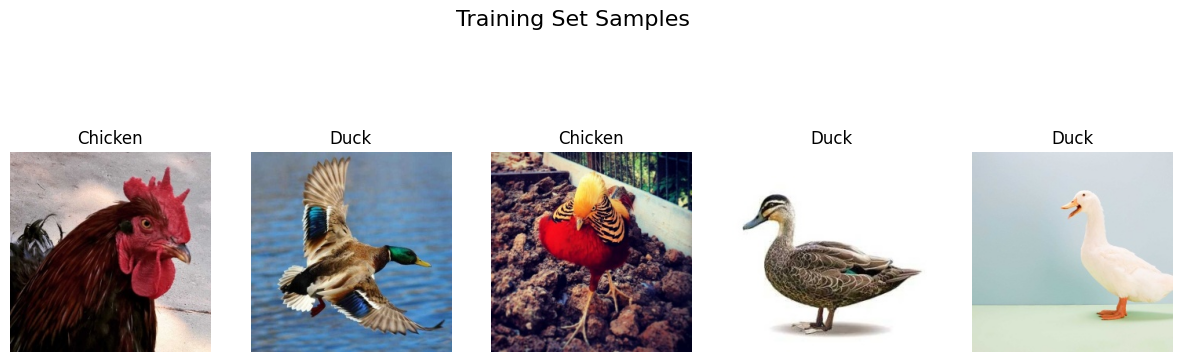

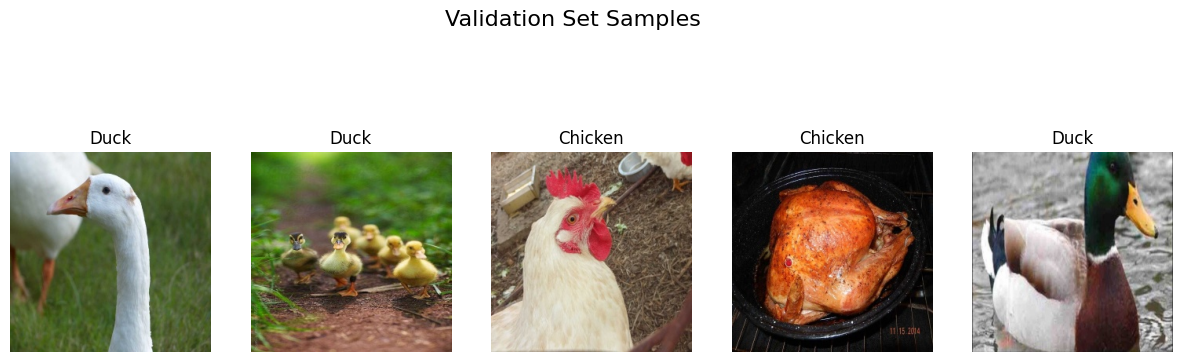

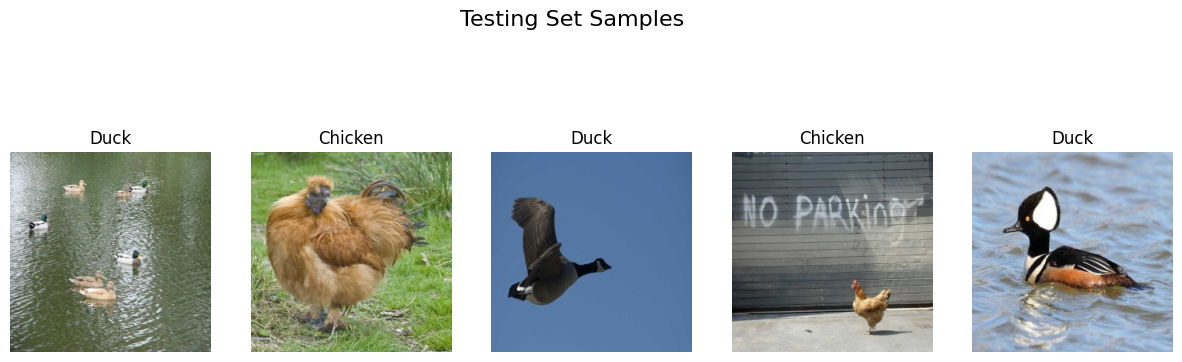

In [19]:
plot_random_images(train_dir, "Training Set Samples")
plot_random_images(val_dir, "Validation Set Samples")
plot_random_images(test_dir, "Testing Set Samples")

Distribution of images

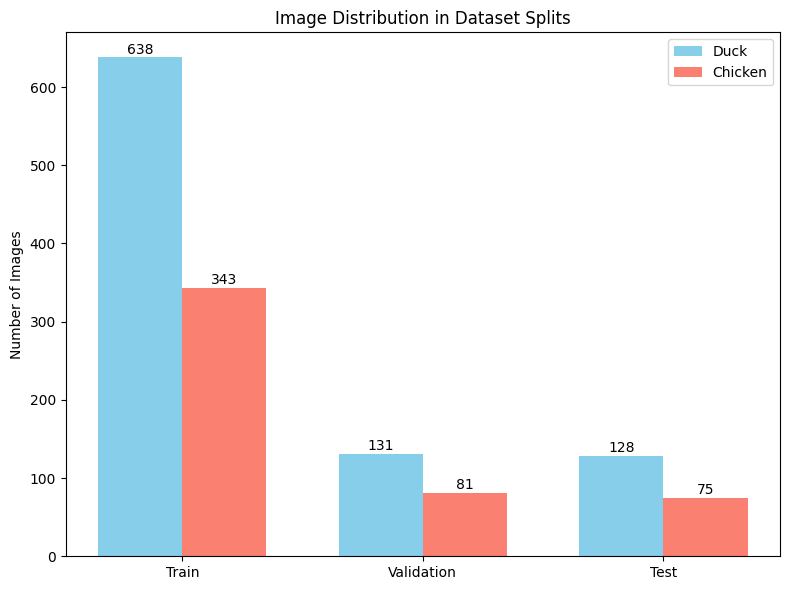

In [29]:
image_counts = count_images("/content/dataset")
plot_image_distribution(image_counts)

In [24]:
train_gen, val_gen, test_gen = create_data_generators(train_dir, val_dir, test_dir)

model, base_model = build_transfer_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])
print("\n Training with frozen base model...")
history1 = model.fit(train_gen, validation_data=val_gen, epochs=10, verbose=1)

print("\nFine-tuning with top layers unfrozen...")
base_model.trainable = True
for layer in base_model.layers[:100]:  # Freezing only the first 100 layers
    layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss="binary_crossentropy", metrics=["accuracy"])
history2 = model.fit(train_gen, validation_data=val_gen, epochs=10, verbose=1)

Found 981 images belonging to 2 classes.
Found 212 images belonging to 2 classes.
Found 203 images belonging to 2 classes.

 Training with frozen base model...
Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 33s 861ms/step - accuracy: 0.7368 - loss: 0.5291 - val_accuracy: 0.9387 - val_loss: 0.2715
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 475ms/step - accuracy: 0.9231 - loss: 0.2587 - val_accuracy: 0.9340 - val_loss: 0.1736
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 403ms/step - accuracy: 0.9431 - loss: 0.1760 - val_accuracy: 0.9481 - val_loss: 0.1371
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 398ms/step - accuracy: 0.9434 - loss: 0.1643 - val_accuracy: 0.9434 - val_loss: 0.1233
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 402ms/step - accuracy: 0.9660 - loss: 0.1266 - val_accuracy: 0.9434 - val_loss: 0.1137
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 406ms/step - accuracy: 0.9703 - loss: 0.0967 - val_accuracy: 0.9434 - val_loss: 0.1066
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 451ms/step - accuracy: 0

In [32]:
generate_classification_report(model, test_gen)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
Classification Report:

              precision    recall  f1-score   support

     chicken       0.96      0.96      0.96        75
        duck       0.98      0.98      0.98       128

    accuracy                           0.97       203
   macro avg       0.97      0.97      0.97       203
weighted avg       0.97      0.97      0.97       203



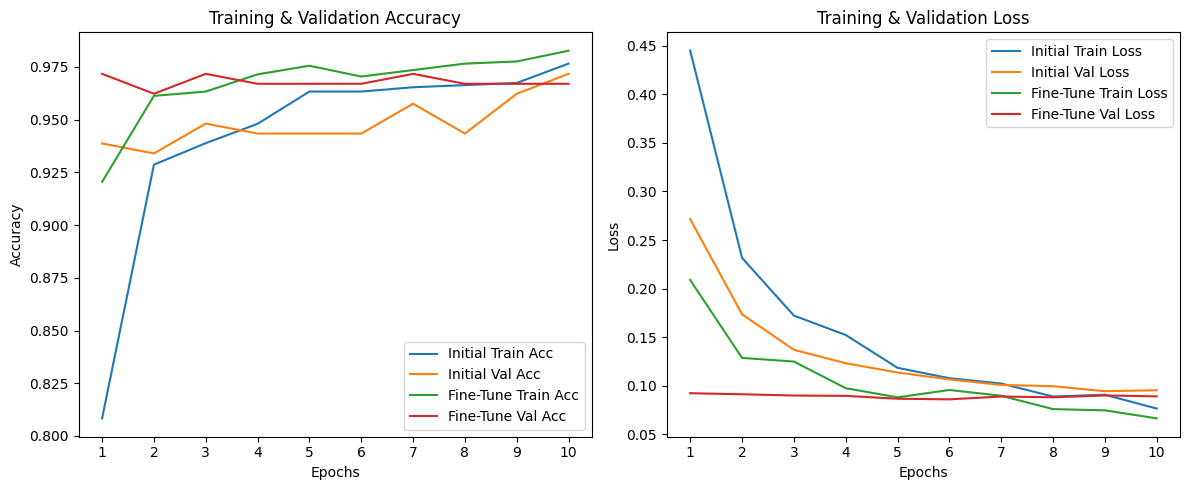

In [31]:
plot_training_metrics(
    history_list=[history1, history2],
    labels=["Initial", "Fine-Tune"]
)
